In [10]:
# Code to test whether this ipynb was already ran before
a = 5 
a

5

This code is used to infer transit shape from input light curve.
It involves following steps:
1. Load ML model
2. Load input data - i.e. the light curves
3. Predict the shapes from the light curves

4. Load True Output (if any)

Load ML model

In [3]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

2024-02-15 13:32:29.866243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 13:32:30.944565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [4]:
model_load = load_model("../ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")


2024-02-15 13:32:33.428276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30924 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Load Input data to infer on

In [5]:
# 1. Load Lightcurve Dataset
lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/random/npy/lc/lc_1_14Feb2024_circle_38_38_px.npy'
test_lc = np.load(lc_dir)

# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

Extended the light curves


Predict Shape

In [6]:
# Test on the ML model - Test Dataset - Original Simulated light curve 
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
test_predict_shape = model_load.predict(test_lc_scaled_append)
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

2024-02-15 13:32:35.998043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 3s 3s/step
Normalized the predicted shape


Plot (a single set) - Adjust index k to get the kth I/O
1. input light curve 
2. predicted output

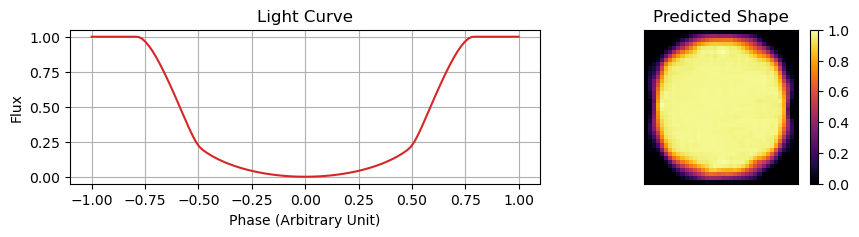

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,2),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title('Light Curve')
axes[0].plot(ph, test_lc_scaled_append[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()


Load True Output if any

In [8]:
shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/random/npy/shape/14Feb2024_circle_38_38_px.npy'
test_shape = np.load(shape_dir)

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)

Miscellance Operations
1. Plot input lightcurve
2. Show predicted output
3. Show true output

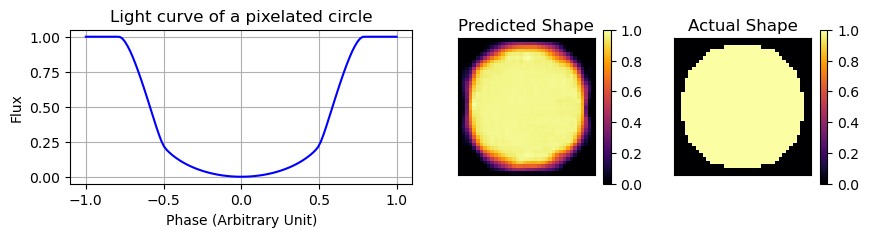

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2),gridspec_kw={'width_ratios': [2,1,1]})  # 1 row, 3 columns
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title('Light curve of a pixelated circle')
axes[0].plot(ph, test_lc_scaled_append[k], color='blue')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')

axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

axes[2].set_title('Actual Shape')
axes[2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[2].imshow(test_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()